<a href="https://colab.research.google.com/github/stmoon/CS470/blob/master/5_Train_and_Test_a_simple_MLP_based_MNIST_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Recommended materials
====

1. Pytorch Official Tutorial \[[Link](https://pytorch.org/tutorials/)\]
2. DeepLearning Zero to All \[[English](https://www.youtube.com/playlist?list=PLlMkM4tgfjnJ3I-dbhO9JTw7gNty6o_2m)\] \[[Korean](https://www.youtube.com/playlist?list=PLQ28Nx3M4JrhkqBVIXg-i5_CVVoS1UzAv)\]
3. Neural Network Programming - Deep Learning with Pytorch \[[English](https://www.youtube.com/playlist?list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG)\]

Pipeline for training and testing a simple MLP MNIST classifier
====

## Step 1: Connect to your Google Drive

It is required if you want to save checkpoints and load them later on

In [0]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Step 2: Import modules

In [0]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

# import TensorBoardColab
!pip install -U tensorboardcolab
from tensorboardcolab import TensorBoardColab

# sometimes it is better to control randomness.
torch.manual_seed(470)
torch.cuda.manual_seed(470)

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


Using TensorFlow backend.


## Step 3: Configure the experiments

In [0]:
# training & optimization hyper-parameters
max_epoch = 10
learning_rate = 0.0001
batch_size = 200
device = 'cuda'

# model hyper-parameters
input_dim = 784 # 28x28=784
hidden_dim = 512
output_dim = 10 

# initialize tensorboard for visualization
# Note : click the Tensorboard link to see the visualization of training/testing results
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://45d2e5d3.ngrok.io


## Step 4: Construct data pipeline

**`torchvision.datasets.MNIST`** will automatically construct **`MNIST`** dataset.

In [0]:
data_dir = os.path.join(gdrive_root, 'my_data')

transform = transforms.ToTensor()

train_dataset = MNIST(data_dir, train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = MNIST(data_dir, train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

## Step 5: Construct a neural network builder

In [0]:
class MyClassifier(nn.Module):
  def __init__(self, input_dim=784, hidden_dim=512, output_dim=10):
    super(MyClassifier, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, output_dim),
    )
    
  def forward(self, x):
    batch_size = x.size(0)
    x = x.view(batch_size, -1)
    outputs = self.layers(x)
    return outputs

## Step 6: Initialize the network and optimizer

In [0]:
my_classifier = MyClassifier(input_dim, hidden_dim, output_dim)
my_classifier = my_classifier.to(device)

optimizer = optim.Adam(my_classifier.parameters(), lr=learning_rate)


## Step 7: Load pre-trained weights if exist

In [0]:
ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
ckpt_path = os.path.join(ckpt_dir, 'lastest.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  best_acc = ckpt['best_acc']
  my_classifier.load_state_dict(ckpt['my_classifier'])
  optimizer.load_state_dict(ckpt['optimizer'])
  print('checkpoint is loaded !')
  print('current best accuracy : %.2f' % best_acc)
else:
  best_acc = 0

checkpoint is loaded !
current best accuracy : 0.97


## Step 8: Train the network

Note : It would be better to save checkpoints periodically, otherwise you'll lose everything you've trained if the session is recycled.

In [0]:
it = 0
train_losses = []
test_losses = []
for epoch in range(max_epoch):
  # train phase
  for inputs, labels in train_dataloader:
    it += 1
    
    # load data to the GPU.
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # feed data into the network and get outputs.
    logits = my_classifier(inputs)
    
    # calculate loss
    # Note: `F.cross_entropy` function receives logits, or pre-softmax outputs, rather than final probability scores.
    loss = F.cross_entropy(logits, labels)
    
    # Note: You should flush out gradients computed at the previous step before computing gradients at the current step. 
    #       Otherwise, gradients will accumulate.
    optimizer.zero_grad()
    
    # backprogate loss.
    loss.backward()
    
    # update the weights in the network.
    optimizer.step()
    
    # calculate accuracy.
    acc = (logits.argmax(dim=1) == labels).float().mean()
    
    if it % 200 == 0:
      tbc.save_value('Loss', 'train_loss', it, loss.item())
      print('[epoch:{}, iteration:{}] train loss : {:.4f} train accuracy : {:.4f}'.format(epoch, it, loss.item(), acc.item()))
    
  # save losses in a list so that we can visualize them later.
  train_losses.append(loss.item())  
    
  # test phase
  n = 0.
  test_loss = 0.
  test_acc = 0.
  for test_inputs, test_labels in test_dataloader:
    test_inputs = test_inputs.to(device)
    test_labels = test_labels.to(device)
    
    logits = my_classifier(test_inputs)
    test_loss += F.cross_entropy(logits, test_labels, reduction='sum')
    test_acc += (logits.argmax(dim=1) == test_labels).float().sum()
    n += inputs.size(0)
    
  test_loss /= n
  test_acc /= n
  test_losses.append(test_loss.item())
  tbc.save_value('Loss', 'test_loss', it, test_loss.item())
  print('[epoch:{}, iteration:{}] test_loss : {:.4f} test accuracy : {:.4f}'.format(epoch, it, test_loss.item(), test_acc.item())) 
  
  tbc.flush_line('train_loss')
  tbc.flush_line('test_loss')
  
  # save checkpoint whenever there is improvement in performance
  if test_acc > best_acc:
    best_acc = test_acc
    # Note: optimizer also has states ! don't forget to save them as well.
    ckpt = {'my_classifier':my_classifier.state_dict(),
            'optimizer':optimizer.state_dict(),
            'best_acc':best_acc}
    torch.save(ckpt, ckpt_path)
    print('checkpoint is saved !')
    
tbc.close()



[epoch:0, iteration:200] train loss : 0.0481 train accuracy : 0.9900
[epoch:0, iteration:300] test_loss : 0.0775 test accuracy : 0.9761
checkpoint is saved !
[epoch:1, iteration:400] train loss : 0.0237 train accuracy : 0.9950
[epoch:1, iteration:600] train loss : 0.0338 train accuracy : 0.9900
[epoch:1, iteration:600] test_loss : 0.0750 test accuracy : 0.9759
[epoch:2, iteration:800] train loss : 0.0369 train accuracy : 0.9800
[epoch:2, iteration:900] test_loss : 0.0744 test accuracy : 0.9764
checkpoint is saved !
[epoch:3, iteration:1000] train loss : 0.0123 train accuracy : 1.0000
[epoch:3, iteration:1200] train loss : 0.0309 train accuracy : 0.9900
[epoch:3, iteration:1200] test_loss : 0.0709 test accuracy : 0.9771
checkpoint is saved !
[epoch:4, iteration:1400] train loss : 0.0342 train accuracy : 0.9950
[epoch:4, iteration:1500] test_loss : 0.0761 test accuracy : 0.9762
[epoch:5, iteration:1600] train loss : 0.0281 train accuracy : 0.9950
[epoch:5, iteration:1800] train loss : 

NameError: ignored

## Step 9: Visualize and analyze the results

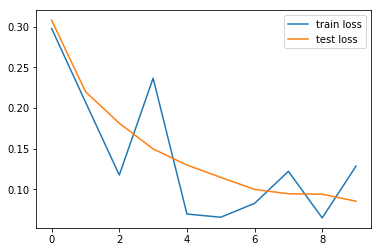

In [0]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

label : 1
prediction : 1


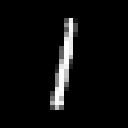

In [0]:
import random
from PIL import Image

num_test_samples = len(test_dataset)
random_idx = random.randint(0, num_test_samples)

topil = transforms.transforms.ToPILImage()
test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(my_classifier(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %i' % test_label)
print('prediction : %i' % test_prediction)

test_image = topil(test_input)
test_image.resize((128, 128))